In [1]:
!curl -OL http://scikit-hep.org/uproot3/examples/HZZ.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  212k  100  212k    0     0  1235k      0 --:--:-- --:--:-- --:--:-- 1230k


In [12]:
import uproot4
import awkward1 as ak
from coffea.nanoevents.methods import vector
import coffea.hist as hist
ak.behavior.update(vector.behavior)

In [13]:
fin = uproot4.open('HZZ.root')
tree = fin['events']

In [14]:
arrays = {k.replace('Electron_', ''): v for k, v in tree.arrays(filter_name="Electron_*", how=dict).items()}

In [15]:
electrons = ak.zip({'x': arrays.pop('Px'),
                    'y': arrays.pop('Py'),
                    'z': arrays.pop("Pz"),
                    't': arrays.pop("E"),
                    },
                    with_name="LorentzVector"
)

In [16]:
arrays = {k.replace('Muon_', ''): v for k,v in tree.arrays(filter_name="Muon_*", how=dict).items()}
muons = ak.zip({'x': arrays.pop('Px'),
                'y': arrays.pop('Py'),
                'z': arrays.pop("Pz"),
                't': arrays.pop("E"),
                },
                with_name="LorentzVector"
)

In [17]:
print("Avg electrons/event: ", ak.sum(ak.num(electrons))/tree.num_entries)
print("Avg muons/event: ", ak.sum(ak.num(muons))/tree.num_entries)

Avg electrons/event:  0.07063197026022305
Avg muons/event:  1.579925650557621


In [18]:
lepton_kinematics = hist.Hist(

    "Events",
    hist.Cat("flavor","Lepton flavor"),
    hist.Bin("pt","$p_{T}$",19,10,100),
    hist.Bin("eta","$\eta$",[-2.5,-1.4,0,1.4,2.5]),
)


lepton_kinematics.fill(
    flavor = "electron",
    pt=ak.flatten(electrons.pt),
    eta=ak.flatten(electrons.eta)

)

lepton_kinematics.fill(
    flavor = "muon",
    pt=ak.flatten(muons.pt),
    eta=ak.flatten(muons.eta)

)

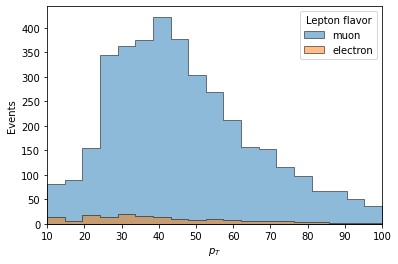

In [19]:
lepton_pt = lepton_kinematics.integrate("eta")

ax = hist.plot1d(

    lepton_pt,
    overlay='flavor',
    stack=True,
    fill_opts = {'alpha':0.5, 'edgecolor':(0,0,0,0.3)}

)

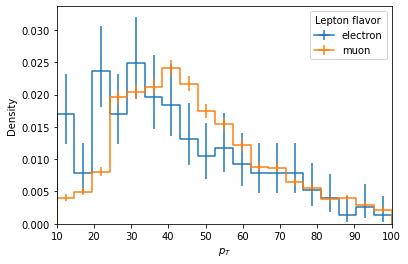

In [38]:
## compare the shape to normalize to 1
lepton_pt.label = "Density"
ax = hist.plot1d(lepton_pt, overlay="flavor",density=True)

In [39]:
# Let's stack them, after defining some nice styling
stack_fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
}
stack_error_opts = {
    'label':'Stat. Unc.',
    'hatch':'///',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}

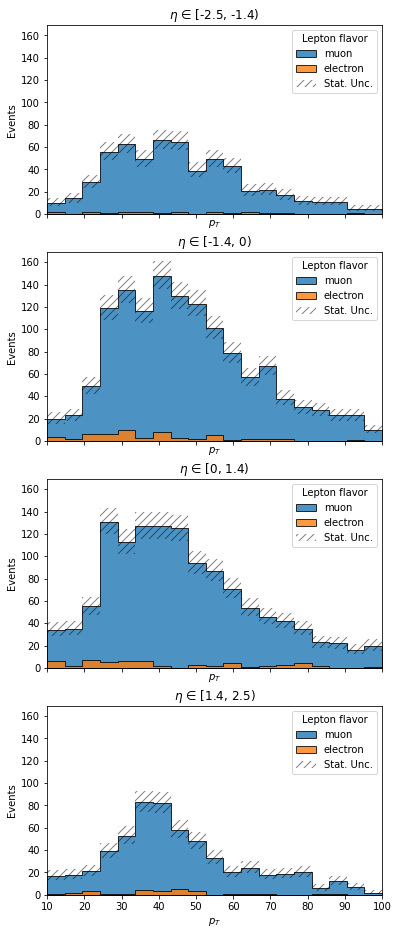

In [40]:
# PT of different eta regions
ax = hist.plotgrid(
    lepton_kinematics,
    row="eta",
    overlay="flavor",
    stack=True,
    fill_opts=stack_fill_opts,
    error_opts=stack_error_opts,
)

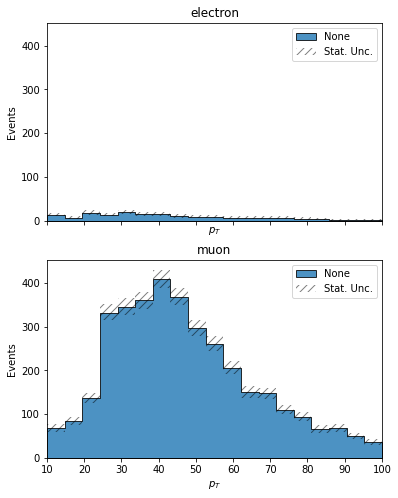

In [57]:
pthist = lepton_kinematics.sum('eta')

ax = hist.plotgrid(

    pthist,
    row='flavor',
    stack=True,
    fill_opts=stack_fill_opts,
    error_opts=stack_error_opts,
)

In [71]:
# Make pseudodata
import numpy as np
pthist = lepton_kinematics.sum('eta')
bin_values = pthist.axis('pt').centers()
poisson_means = pthist.sum('flavor').values()[()]
values = np.repeat(bin_values, np.random.poisson(poisson_means))
pthist.fill(flavor='pseudodata',pt=values)

# Set nicer labels, by accessing the string bins' label property
pthist.axis('flavor').index('electron').label = 'e Flavor'
pthist.axis('flavor').index('muon').label = r'$\mu$ Flavor'
pthist.axis('flavor').index('pseudodata').label = r'Pseudodata from e/$\mu$'

import re
notdata = re.compile('(?!pseudodata)')

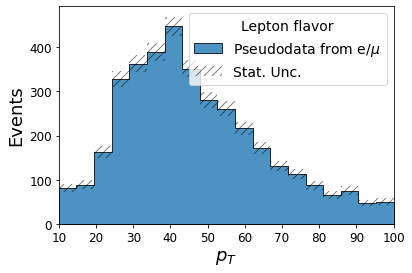

In [78]:
ax = hist.plot1d(

    pthist['pseudodata'],
    #row='flavor',
    overlay='flavor',
    stack=True,
    fill_opts=stack_fill_opts,
    error_opts=stack_error_opts,
)

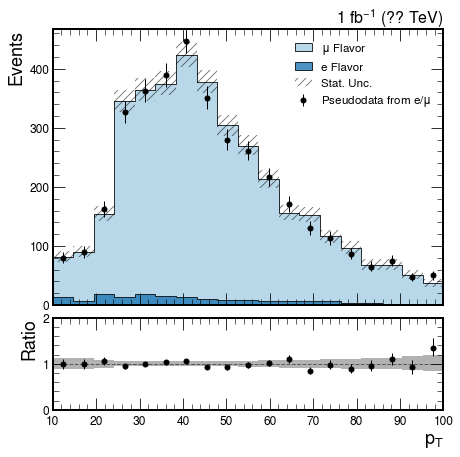

In [89]:
import matplotlib.pyplot as plt
import mplhep

plt.style.use(mplhep.style.CMS)

## --- font and graphic setting
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

## --- MC
hist.plot1d(

    pthist[notdata],
    overlay="flavor",
    ax=ax,
    clear=False,
    stack=True,
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts

)

# --- Data
hist.plot1d(
    pthist['pseudodata'],
    overlay="flavor",
    ax=ax,
    clear=False,
    error_opts=data_err_opts
)

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.set_xlabel(None)
leg = ax.legend()

# --- Raio plot
hist.plotratio(
    num=pthist['pseudodata'].sum("flavor"),
    denom=pthist[notdata].sum("flavor"),
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

# --- Add some labels
lumi = plt.text(1., 1., r"1 fb$^{-1}$ (?? TeV)",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )